In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

In [13]:
## Get input data
# Download stock data
symbol = "TSLA"
data = yf.download(symbol, start="2020-01-01", end="2023-09-01")

# VIX index input
vix = yf.download('^VIX', start="2020-01-01", end="2023-09-01")
data['VIX'] = vix['Close']

# risk free rate, input
rf = yf.download('^TNX', start="2020-01-01", end="2023-09-01")
data['Risk_Free_Rate'] = rf['Close'] / 100 # percentage

# drop the NaN
data = data.dropna()

# data sample
df = data.loc[:,['Close','Volume','VIX','Risk_Free_Rate']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
df

,Close,Volume,VIX,Risk_Free_Rate
Date,,,,
2020-01-02,28.684000,142981500,12.47,0.01882
2020-01-03,29.534000,266677500,14.02,0.01788
2020-01-06,30.102667,151995000,13.85,0.01811
2020-01-07,31.270666,268231500,13.79,0.01827
2020-01-08,32.809334,467164500,13.45,0.01874
...,...,...,...,...
2023-08-25,238.589996,106612200,15.68,0.04239
2023-08-28,238.820007,107673700,15.08,0.04212
2023-08-29,257.179993,134047600,14.45,0.04122


In [15]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split train and test set
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# calling the create dataset function to split the data into 
# input output datasets with time step 60
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))  
model.add(LSTM(50))
model.add(Dropout(0.2))  
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

# check the running time
start_time = time.time()

# Model training
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
          epochs=100, batch_size=64, verbose=1)

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            11000     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

Epoch 68/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 69/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 70/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0046 - val_loss: 0.0024
Epoch 71/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 72/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 73/100
10/10 [==============================] - 1s 106ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 74/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 75/100
10/10 [==============================] - 1s 105ms/step - loss: 0.0038 - val_loss: 0.0068
Epoch 76/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 77/100
10/10 [==============================] - 1s 107ms/step - loss: 0.0040

In [16]:
# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

7/7 [==============================] - 0s 21ms/step


In [17]:
train_predict = scaler.inverse_transform(np.c_[train_predict, np.zeros((train_predict.shape[0], 3))])[:, 0]
test_predict = scaler.inverse_transform(np.c_[test_predict, np.zeros((test_predict.shape[0], 3))])[:, 0]

# We need to reshape Y_train and Y_test to add the features dimensions back that we dropped before 
# since the scaler expects the same number of features to inverse_transform
# As the scaler was fit on data with 4 features, we need to transform it back accordingly.

# First, reshape Y_train and Y_test to the original shape
Y_train = Y_train.reshape(-1, 1)
Y_train = np.c_[Y_train, np.zeros((Y_train.shape[0], df.shape[1]-1))]  # df.shape[1]-1 because we don't have 'Open', 'High', 'Low'
Y_test = Y_test.reshape(-1, 1)
Y_test = np.c_[Y_test, np.zeros((Y_test.shape[0], df.shape[1]-1))]  # df.shape[1]-1 for the same reason

# Now, use inverse_transform to scale back to original representation
Y_train = scaler.inverse_transform(Y_train)[:, 0]
Y_test = scaler.inverse_transform(Y_test)[:, 0]

# Now calculate RMSE in the original scale
print("Train RMSE: ", np.sqrt(mean_squared_error(Y_train, train_predict)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Y_test, test_predict)))


Train RMSE:  14.823461294480635
Test RMSE:  17.77136454302992


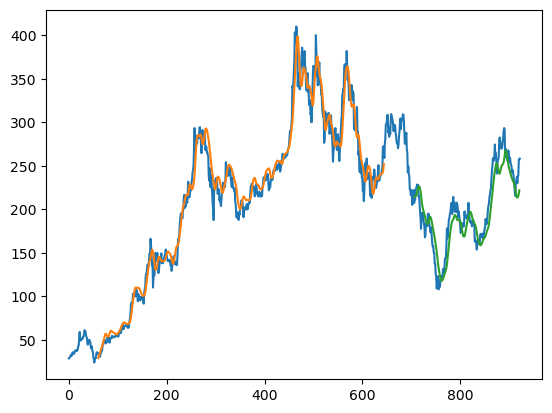

In [18]:
# Plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict) + time_step, 0] = train_predict

testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, 0] = test_predict

plt.plot(scaler.inverse_transform(scaled_data)[:, 0])
plt.plot(trainPredictPlot[:, 0])
plt.plot(testPredictPlot[:, 0])
plt.show()